
### Lab Introduction

The lab content for this course will consist of a number of lab exercises that are designed to familiarise you with the course content and prepare you for the summative assignments. Each of the labs will have a practical and theoretical component and all work should be completed in the notebook provided. The labs are designed to be run on the university vLab server however can be run locally provided you have set up the appropriate Python environments. 

### Lab 1

In this lab exercise, we will introduce the basics required for this module including image loading, output and manipulation. 

You will look at applying edge detectors to images and comparing two different methods. 

At this stage, we will assume that you are able to use Python, and understand its basic use. 

##### Introduction

First we will cover some basics regarding Python and Image Manipulation.

The first step is importing the required packages. In this assignment we will be using scikit-image, MatPlotLib and Numpy. We have also provided helper functions for displaying the images inline. Check that your environment is configured correctly by running the section below. If this section fails, refer to the README on how to set up the environment.

In [28]:
# Imports
import skimage
import scipy
from matplotlib import pyplot as plt
import numpy as np

In order to load images we use the imread function which is part of scikit-image. Images can be displayed using the show_rgb_image helper function. Read through this function to understand how it works. We can also see the raw image data by printing the variable using `print`. As can be seen, by default in Skimage image pixels are represented as bytes with a range of 0-255.

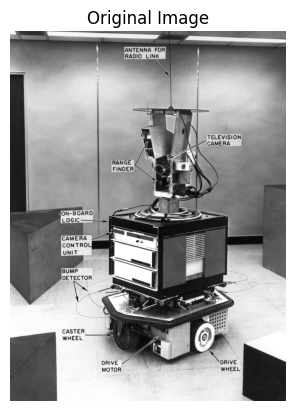

Shakey raw values [[254 254 254 ... 131 122 122]
 [254 254 254 ... 120 113 113]
 [254 254 254 ... 121 113 113]
 ...
 [ 83  81  78 ...  39  39  39]
 [ 83  81  78 ...  41  41  41]
 [ 83  81  78 ...  43  43  43]]


In [29]:
# Read image
shakey = skimage.io.imread('shakey.jpg')[:,:,0] #Extract the Green Channel

# Display the image
plt.imshow(shakey,cmap="gray")
plt.title("Original Image")
plt.axis('off')
plt.show()

print("Shakey raw values", shakey)

In scikit we perform convolution using the convolve2d function. Kernels can be defined as numpy arrays as seen below. A detailed guide to this function can be found here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In [30]:
sobel_x = np.array(
    [[1,0,-1],
     [2,0,-2],
     [1,0,-1]])

sobel_y = np.array(
    [[1,2,1],
     [0,0,0],
     [-1,-2,-1]])

print(sobel_y)

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


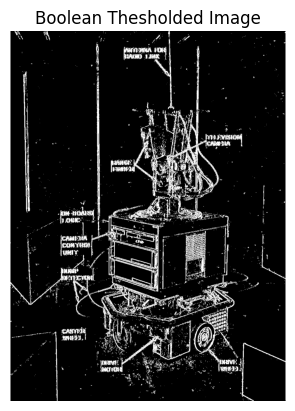

In [31]:
# Applying a filter
# We convert the output type to floats in order to preserve negative gradients
# We can also threshold the image using the > operator
threshold_shakey_sobel_x = abs(scipy.signal.convolve2d(shakey, sobel_x))>50

plt.imshow(threshold_shakey_sobel_x,cmap="gray")
plt.title("Boolean Thesholded Image")
plt.axis('off')
plt.show()

So far we have covered how to load images into Python, perform basic manipulation such as convolution and finally output images. The following tasks are designed to recap on content that has been covered in the Computer Vision module. Explore online documentation to implement the following tasks.

#### Task 1: Reimplement the the block above using OpenCV

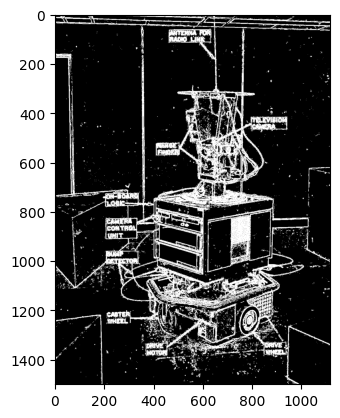

In [32]:
import cv2

## Apply the filter using OpenCV
sobelx = cv2.Sobel(shakey, cv2.CV_64F, dx=1, dy=0, ksize=3)  # x direction
sobely = cv2.Sobel(shakey, cv2.CV_64F, dx=0, dy=1, ksize=3)  # y direction
# calculate the gradient
sobel_combined = cv2.magnitude(sobelx, sobely)

# set threshold
threshold = 50

# cv.threshold
_, thresholded = cv2.threshold(sobel_combined, threshold, 255, cv2.THRESH_BINARY)

# convert to int8
thresholded = np.uint8(thresholded)
plt.imshow(thresholded, cmap='gray')

#### Task 2: Apply Canny Edge Detection to the original shakey image using both OpenCV and Scipy

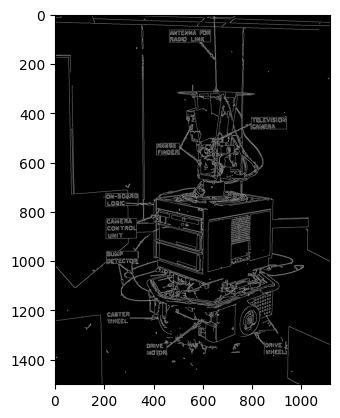

In [33]:
## Apply Canny Edge Detection OpenCV

# set Canny threshold
threshold1 = 50  # minimum threshold
threshold2 = 250  # maximum threshold

# Canny edge detection
edges = cv2.Canny(shakey, threshold1, threshold2)
plt.imshow(edges, cmap='gray')

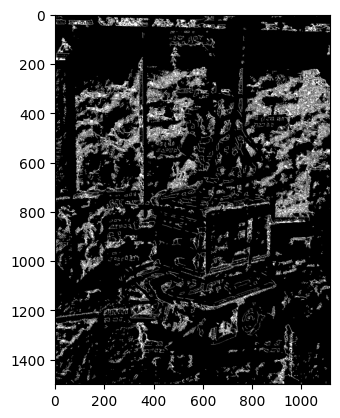

In [60]:
from scipy import ndimage


## Apply Canny Edge Detection Scipy
def gaussian_filter(image, sigma=1.0):
    """Apply Gaussian filter to smooth the image."""
    return ndimage.gaussian_filter(image, sigma)

def compute_gradient(image):
    """Compute gradient magnitude and direction using Sobel filters."""
    sobel_x = ndimage.sobel(image, axis=0)  # Gradient in x direction
    sobel_y = ndimage.sobel(image, axis=1)  # Gradient in y direction
    gradient_magnitude = np.hypot(sobel_x, sobel_y)  # Magnitude
    gradient_direction = np.arctan2(sobel_y, sobel_x)  # Direction
    return gradient_magnitude, gradient_direction

def non_max_suppression(gradient_magnitude, gradient_direction):
    """Suppress non-maximum pixels in the gradient magnitude."""
    H, W = gradient_magnitude.shape
    suppressed = np.zeros((H, W), dtype=np.float64)
    angle = gradient_direction * 180 / np.pi  # Convert radians to degrees
    angle[angle < 0] += 180  # Make angles positive

    for i in range(1, H - 1):
        for j in range(1, W - 1):
            q, r = 255, 255  # Initialize neighbors

            # Horizontal edge (0 degrees)
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = gradient_magnitude[i, j + 1]
                r = gradient_magnitude[i, j - 1]
            # Diagonal edge (45 degrees)
            elif 22.5 <= angle[i, j] < 67.5:
                q = gradient_magnitude[i + 1, j - 1]
                r = gradient_magnitude[i - 1, j + 1]
            # Vertical edge (90 degrees)
            elif 67.5 <= angle[i, j] < 112.5:
                q = gradient_magnitude[i + 1, j]
                r = gradient_magnitude[i - 1, j]
            # Diagonal edge (135 degrees)
            elif 112.5 <= angle[i, j] < 157.5:
                q = gradient_magnitude[i - 1, j - 1]
                r = gradient_magnitude[i + 1, j + 1]

            # Suppress non-maximum values
            if gradient_magnitude[i, j] >= q and gradient_magnitude[i, j] >= r:
                suppressed[i, j] = gradient_magnitude[i, j]

    return suppressed

def double_threshold(image, low_threshold, high_threshold):
    """Apply double threshold to identify strong, weak, and non-edges."""
    strong = high_threshold
    weak = low_threshold
    result = np.zeros_like(image, dtype=np.int32)

    strong_pixels = (image >= strong)
    weak_pixels = ((image >= weak) & (image < strong))

    result[strong_pixels] = 255  # Strong edge
    result[weak_pixels] = 75  # Weak edge

    return result

def edge_tracking(image, weak=75, strong=255):
    """Track edges by hysteresis."""
    H, W = image.shape
    for i in range(1, H - 1):
        for j in range(1, W - 1):
            if image[i, j] == weak:
                if 255 in [image[i + 1, j - 1], image[i + 1, j], image[i + 1, j + 1],
                           image[i, j - 1], image[i, j + 1],
                           image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1]]:
                    image[i, j] = strong
                else:
                    image[i, j] = 0
    return image

def canny_edge_detection(image, sigma=3.0, low_threshold=50, high_threshold=250):
    """Perform Canny Edge Detection."""
    # 1. Apply Gaussian smoothing
    smoothed = gaussian_filter(image, sigma)

    # 2. Compute gradient magnitude and direction
    gradient_magnitude, gradient_direction = compute_gradient(smoothed)

    # 3. Apply non-maximum suppression
    suppressed = non_max_suppression(gradient_magnitude, gradient_direction)

    # 4. Apply double threshold
    thresholded = double_threshold(suppressed, low_threshold, high_threshold)

    # 5. Perform edge tracking by hysteresis
    edges = edge_tracking(thresholded)

    return thresholded, edges

# Canny edge detection with scipy
thresholded, edges = canny_edge_detection(shakey, sigma=5.0, low_threshold=20, high_threshold=300)
plt.imshow(edges, cmap='gray')

#### Task 3: Apply Straight line hough transform to the canny image using either OpenCV or Scipy 

In [65]:
import math
## Straight line hough transform

# Canny edge detection
edges = cv2.Canny(shakey, 50, 200, None, 3)
# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

lines = cv2.HoughLines(edges, 1, np.pi / 180, 150, None, 0, 0)

# Draw the lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (255, 0, 0), 3, cv2.LINE_AA)

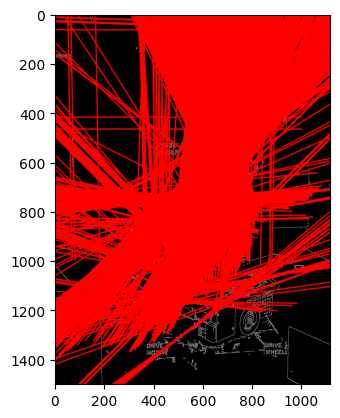

In [66]:
plt.imshow(cdst)

# Questions

Since there has only been one week of teaching, these questions primarily pertain to content from the previous computer vision module. If you are not familiar with these topics, please research them online. Write 2-3 sentences per answer.

#### Why is Gaussian smoothing typically applied before detecting edges in the Canny algorithm?

The difference between Sobel and Canny is that Canny use Gaussian filter to reduce the noise. Since edge detection is susceptible to noise in the image.

#### What are some practical applications of the Canny edge detection algorithm in real-world scenarios?

1. Medical imaging
2. Autonomous vehicles for detecting lanes, road signs, and pedestrians.
3. Optical character recognition (OCR) systems to identify text boundaries.

#### How would you implement convolution for large images efficiently?

We can use separable kernels. For certain filters (e.g., Gaussian), we can decompose a 2D kernel into two 1D kernels (horizontal and vertical).